In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP and Text Processing
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

# For saving the model
import joblib

In [5]:
# Step 2: Download required NLTK data and load dataset
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    print("NLTK data downloaded successfully!")
except:
    print("NLTK data already exists or download failed")

# Load the dataset
df = pd.read_csv('news.csv')

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

NLTK data downloaded successfully!

Dataset shape: (6335, 4)

Column names: ['Unnamed: 0', 'title', 'text', 'label']

First few rows:
   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


=== Dataset Overview ===
Total articles: 6335
Missing values:
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Data types:
Unnamed: 0     int64
title         object
text          object
label         object
dtype: object

=== Label Distribution ===
label
REAL    3171
FAKE    3164
Name: count, dtype: int64

Percentage distribution:
label
REAL    50.055249
FAKE    49.944751
Name: proportion, dtype: float64


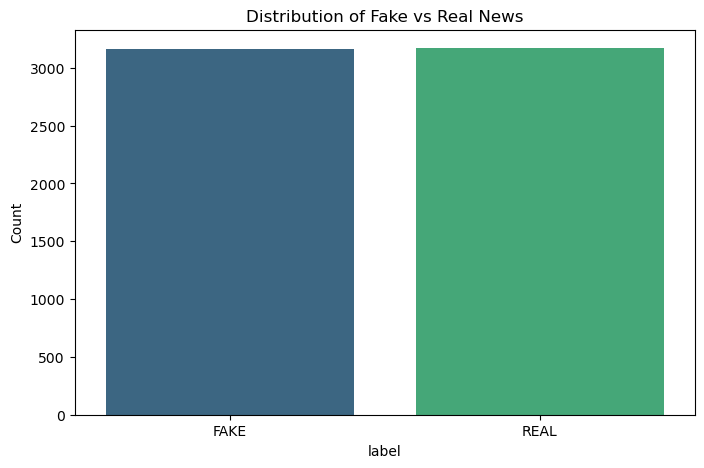


Unique labels: ['FAKE' 'REAL']


In [6]:
# Step 3: Exploratory Data Analysis
print("=== Dataset Overview ===")
print(f"Total articles: {len(df)}")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nData types:\n{df.dtypes}")

# Check label distribution
print(f"\n=== Label Distribution ===")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nPercentage distribution:")
print(df['label'].value_counts(normalize=True) * 100)

# Visualize label distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Distribution of Fake vs Real News')
plt.ylabel('Count')
plt.show()

# Check for any other unique values in label column
print(f"\nUnique labels: {df['label'].unique()}")

=== Text Length Analysis ===
Title length statistics:
count    6335.000000
mean       65.277664
std        23.733657
min         1.000000
25%        49.000000
50%        64.000000
75%        78.000000
max       289.000000
Name: title_length, dtype: float64

Text length statistics:
count      6335.000000
mean       4707.250355
std        5090.956446
min           1.000000
25%        1741.500000
50%        3642.000000
75%        6192.000000
max      115372.000000
Name: text_length, dtype: float64

Word count statistics:
count     6335.000000
mean       776.300710
std        854.333358
min          0.000000
25%        289.000000
50%        597.000000
75%       1024.000000
max      20891.000000
Name: word_count, dtype: float64


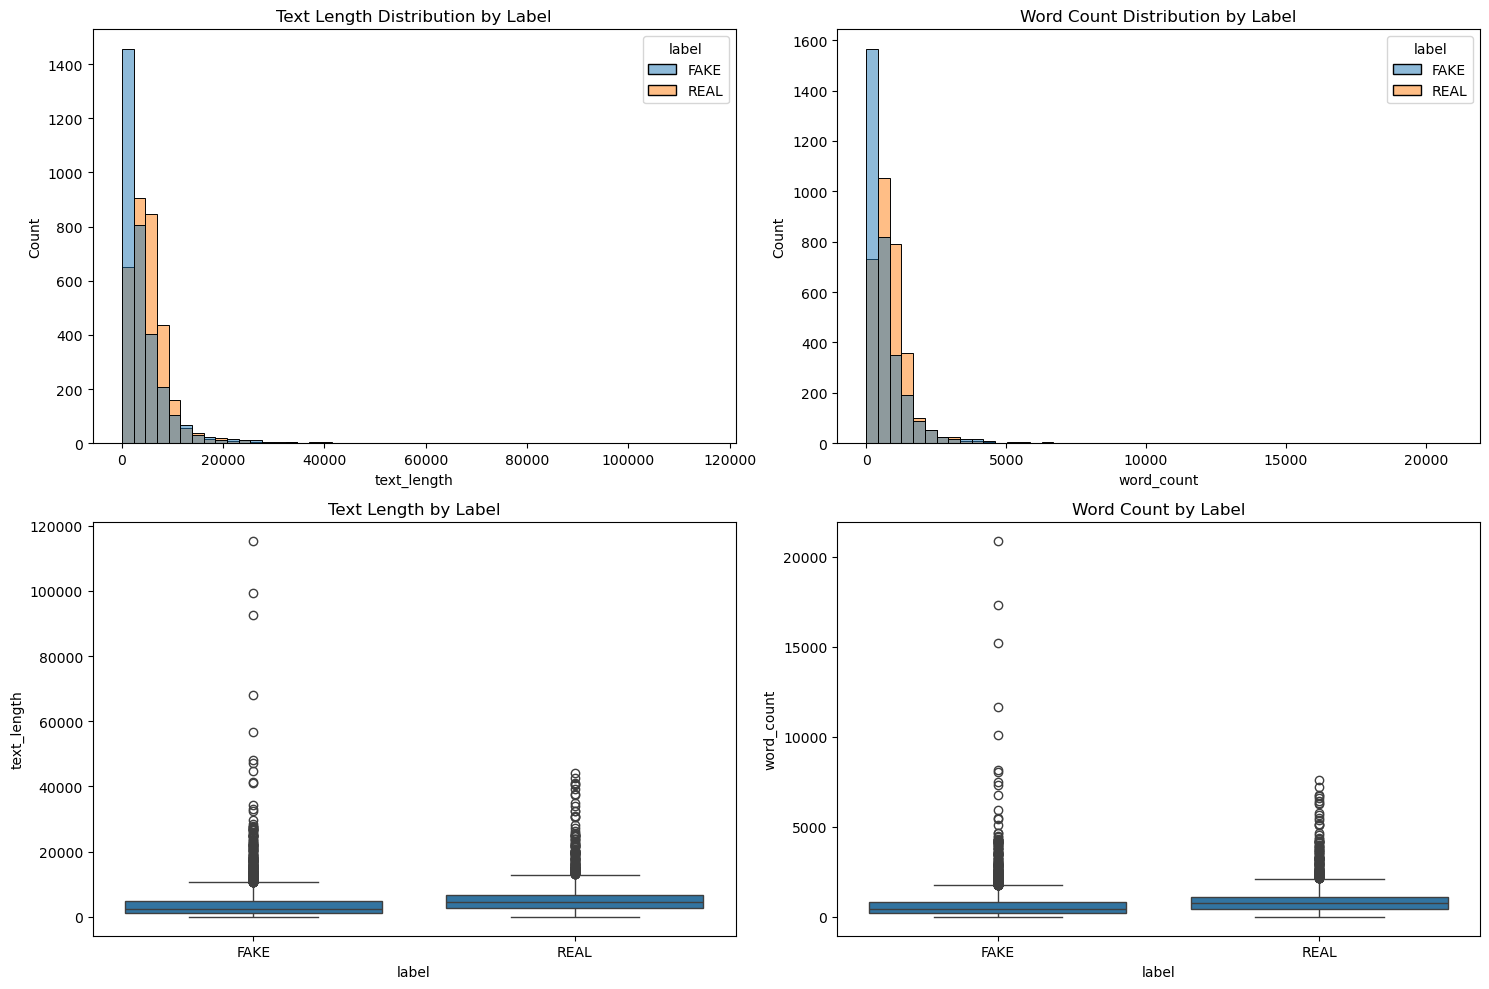


=== Sample Real News ===
U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.

Kerry said...

=== Sample Fake News ===
Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war wit...


In [7]:
# Step 4: Analyze text characteristics
print("=== Text Length Analysis ===")

# Calculate text lengths
df['title_length'] = df['title'].str.len()
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Display statistics
print("Title length statistics:")
print(df['title_length'].describe())
print("\nText length statistics:")
print(df['text_length'].describe())
print("\nWord count statistics:")
print(df['word_count'].describe())

# Visualize text lengths by label
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length distribution
sns.histplot(data=df, x='text_length', hue='label', bins=50, ax=axes[0,0])
axes[0,0].set_title('Text Length Distribution by Label')

# Word count distribution
sns.histplot(data=df, x='word_count', hue='label', bins=50, ax=axes[0,1])
axes[0,1].set_title('Word Count Distribution by Label')

# Box plots
sns.boxplot(data=df, x='label', y='text_length', ax=axes[1,0])
axes[1,0].set_title('Text Length by Label')

sns.boxplot(data=df, x='label', y='word_count', ax=axes[1,1])
axes[1,1].set_title('Word Count by Label')

plt.tight_layout()
plt.show()

# Show sample texts
print(f"\n=== Sample Real News ===")
print(df[df['label']=='REAL']['text'].iloc[0][:200] + "...")
print(f"\n=== Sample Fake News ===")
print(df[df['label']=='FAKE']['text'].iloc[0][:200] + "...")

In [8]:
# Step 5: Define text preprocessing functions
def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

def preprocess_text(text):
    """
    Complete preprocessing pipeline
    """
    # Clean the text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Join tokens back to string
    return ' '.join(tokens)

# Test the preprocessing functions
sample_text = df['text'].iloc[0]
print("Original text (first 200 chars):")
print(sample_text[:200])
print("\nCleaned text (first 200 chars):")
cleaned = preprocess_text(sample_text)
print(cleaned[:200])
print(f"\nOriginal length: {len(sample_text.split())}")
print(f"Processed length: {len(cleaned.split())}")

Original text (first 200 chars):
Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war wit

Cleaned text (first 200 chars):
daniel greenfield shillman journal fellow freedom center new york writer focus radic islam final stretch elect hillari rodham clinton gone war fbi word unpreced thrown around often elect ought retir s

Original length: 1296
Processed length: 674


In [9]:
# Step 6: Apply preprocessing to the entire dataset
print("Preprocessing all texts...")
print("This may take a few minutes...")

# Combine title and text for better feature representation
df['combined_text'] = df['title'] + ' ' + df['text']

# Apply preprocessing
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Check results
print("Preprocessing completed!")
print(f"\nProcessed dataset info:")
print(f"Average processed text length: {df['processed_text'].str.len().mean():.0f} characters")
print(f"Average processed word count: {df['processed_text'].str.split().str.len().mean():.0f} words")

# Remove empty texts (if any)
initial_count = len(df)
df = df[df['processed_text'].str.len() > 0]
final_count = len(df)
print(f"\nRemoved {initial_count - final_count} empty texts")
print(f"Final dataset size: {final_count}")

# Show sample of processed text
print("\n=== Sample Processed Text ===")
print(f"Label: {df.iloc[0]['label']}")
print(f"Processed: {df.iloc[0]['processed_text'][:150]}...")

# Drop unnecessary columns to save memory
df = df[['label', 'processed_text']].copy()
print(f"\nDataset columns: {df.columns.tolist()}")

Preprocessing all texts...
This may take a few minutes...
Preprocessing completed!

Processed dataset info:
Average processed text length: 2837 characters
Average processed word count: 432 words

Removed 0 empty texts
Final dataset size: 6335

=== Sample Processed Text ===
Label: FAKE
Processed: smell hillari fear daniel greenfield shillman journal fellow freedom center new york writer focus radic islam final stretch elect hillari rodham clint...

Dataset columns: ['label', 'processed_text']


In [10]:
# Step 7: Split data and create TF-IDF vectors
from sklearn.model_selection import train_test_split

print("=== Splitting Dataset ===")
# Prepare features and target
X = df['processed_text']
y = df['label']

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Training label distribution:\n{y_train.value_counts()}")

# Create TF-IDF Vectorizer
print("\n=== Creating TF-IDF Vectors ===")
tfidf = TfidfVectorizer(
    max_features=10000,  # Limit to top 10k features
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.95,        # Ignore terms that appear in more than 95% of documents
    ngram_range=(1, 2)  # Use both unigrams and bigrams
)

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
print(f"Sample feature names: {tfidf.get_feature_names_out()[:10].tolist()}")

print("\n=== Data Ready for Model Training ===")

=== Splitting Dataset ===
Training set size: 5068
Testing set size: 1267
Training label distribution:
label
REAL    2537
FAKE    2531
Name: count, dtype: int64

=== Creating TF-IDF Vectors ===
TF-IDF matrix shape: (5068, 10000)
Vocabulary size: 10000
Sample feature names: ['aaron', 'abandon', 'abc', 'abc news', 'abc week', 'abdeslam', 'abdulazeez', 'abdullah', 'abedin', 'abid']

=== Data Ready for Model Training ===


In [11]:
# Step 8: Train and evaluate both models
from sklearn.metrics import classification_report, confusion_matrix

print("=== Training Models ===")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB()
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label='FAKE')
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': y_pred
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Detailed classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Compare models
print("\n=== Model Comparison ===")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'F1 Score': [results[model]['f1_score'] for model in results.keys()]
})
print(comparison_df)

=== Training Models ===

--- Training Logistic Regression ---
Accuracy: 0.9219
F1 Score: 0.9234

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        FAKE       0.90      0.94      0.92       633
        REAL       0.94      0.90      0.92       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267


--- Training Naive Bayes ---
Accuracy: 0.8816
F1 Score: 0.8851

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

        FAKE       0.86      0.91      0.89       633
        REAL       0.91      0.85      0.88       634

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267


=== Model Comparison ===
                 Model  Accuracy  F1 Score
0  Logistic Regression  0.921

=== Best Model: Logistic Regression ===
Final Accuracy: 0.9219
Final F1 Score: 0.9234


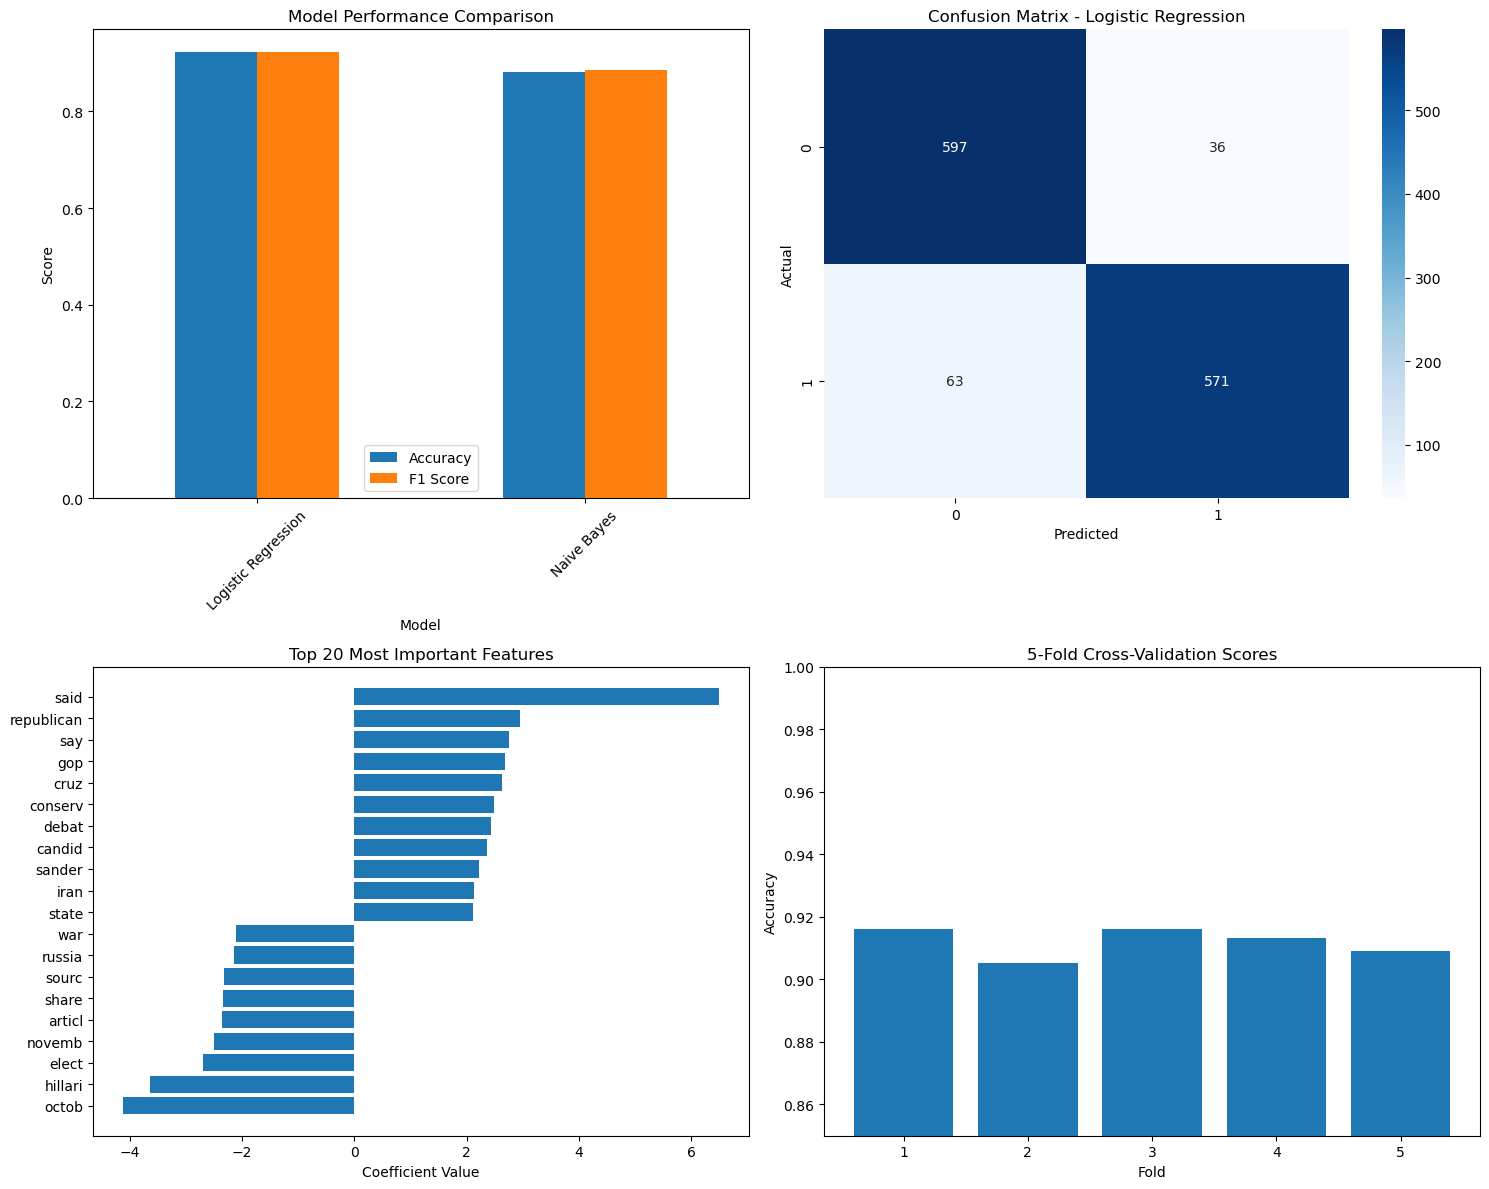


Cross-validation mean score: 0.9120 (+/- 0.0084)

=== Saving Model ===
Model and vectorizer saved successfully!
Files created: fake_news_model.pkl, tfidf_vectorizer.pkl


In [12]:
# Step 9: Visualize results and save the best model
import matplotlib.pyplot as plt
import seaborn as sns

# Select best model
best_model_name = 'Logistic Regression'
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"=== Best Model: {best_model_name} ===")
print(f"Final Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Final F1 Score: {results[best_model_name]['f1_score']:.4f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model comparison
comparison_df.plot(x='Model', y=['Accuracy', 'F1 Score'], kind='bar', ax=axes[0,0])
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_ylabel('Score')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title(f'Confusion Matrix - {best_model_name}')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. Feature importance (top 20 features)
feature_names = tfidf.get_feature_names_out()
coefficients = best_model.coef_[0]
top_features = np.argsort(np.abs(coefficients))[-20:]
feature_importance = pd.DataFrame({
    'feature': feature_names[top_features],
    'importance': coefficients[top_features]
})
feature_importance = feature_importance.sort_values('importance')

axes[1,0].barh(range(len(feature_importance)), feature_importance['importance'])
axes[1,0].set_yticks(range(len(feature_importance)))
axes[1,0].set_yticklabels(feature_importance['feature'])
axes[1,0].set_title('Top 20 Most Important Features')
axes[1,0].set_xlabel('Coefficient Value')

# 4. Cross-validation scores
cv_scores = cross_val_score(best_model, X_train_tfidf, y_train, cv=5)
axes[1,1].bar(range(1, 6), cv_scores)
axes[1,1].set_title('5-Fold Cross-Validation Scores')
axes[1,1].set_xlabel('Fold')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].set_ylim(0.85, 1.0)

plt.tight_layout()
plt.show()

print(f"\nCross-validation mean score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Save the model and vectorizer
print("\n=== Saving Model ===")
joblib.dump(best_model, 'fake_news_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("Model and vectorizer saved successfully!")
print("Files created: fake_news_model.pkl, tfidf_vectorizer.pkl")

In [13]:
# Step 10: Create prediction function and test with examples
def predict_news(text, model=best_model, vectorizer=tfidf, preprocess_func=preprocess_text):
    """
    Predict if a news article is fake or real
    Returns prediction and confidence score
    """
    # Preprocess the text
    processed_text = preprocess_func(text)
    
    # Vectorize
    text_vector = vectorizer.transform([processed_text])
    
    # Predict
    prediction = model.predict(text_vector)[0]
    confidence = model.predict_proba(text_vector)[0]
    
    # Get confidence for the predicted class
    if prediction == 'FAKE':
        conf_score = confidence[0]  # FAKE is typically index 0
    else:
        conf_score = confidence[1]  # REAL is typically index 1
    
    return prediction, conf_score

# Test with sample articles from our dataset
print("=== Testing Prediction Function ===")

# Test with a real news sample
real_sample = df[df['label'] == 'REAL']['processed_text'].iloc[5]
real_pred, real_conf = predict_news(real_sample)
print(f"\nReal News Sample:")
print(f"Text: {real_sample[:100]}...")
print(f"Prediction: {real_pred}")
print(f"Confidence: {real_conf:.4f}")

# Test with a fake news sample
fake_sample = df[df['label'] == 'FAKE']['processed_text'].iloc[5]
fake_pred, fake_conf = predict_news(fake_sample)
print(f"\nFake News Sample:")
print(f"Text: {fake_sample[:100]}...")
print(f"Prediction: {fake_pred}")
print(f"Confidence: {fake_conf:.4f}")

# Test with custom text
custom_text = """
Breaking: Scientists have discovered that drinking coffee made from beans 
grown on Mars significantly increases human lifespan by 200 years. 
The study was conducted by the Intergalactic Health Institute.
"""

custom_pred, custom_conf = predict_news(custom_text)
print(f"\nCustom Text Test:")
print(f"Text: {custom_text.strip()}")
print(f"Prediction: {custom_pred}")
print(f"Confidence: {custom_conf:.4f}")

print(f"\n=== Model Summary ===")
print(f"Final Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Test F1 Score: {results[best_model_name]['f1_score']:.4f}")
print(f"Cross-validation Score: {cv_scores.mean():.4f}")

=== Testing Prediction Function ===

Real News Sample:
Text: three clinton iowa glimps fire elud hillari clinton campaign cedar rapid iowa one wonder ralli entir...
Prediction: REAL
Confidence: 0.8654

Fake News Sample:
Text: strong solar storm tech risk today news oct video click learn alexandra person essenc psychic protec...
Prediction: FAKE
Confidence: 0.9352

Custom Text Test:
Text: Breaking: Scientists have discovered that drinking coffee made from beans 
grown on Mars significantly increases human lifespan by 200 years. 
The study was conducted by the Intergalactic Health Institute.
Prediction: FAKE
Confidence: 0.8794

=== Model Summary ===
Final Model: Logistic Regression
Test Accuracy: 0.9219
Test F1 Score: 0.9234
Cross-validation Score: 0.9120


In [17]:
# Step 11: Create Streamlit application code (Fixed encoding)
streamlit_code = '''
import streamlit as st
import joblib
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np

# Download required NLTK data
@st.cache_resource
def download_nltk_data():
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        nltk.download('punkt_tab', quiet=True)
    except:
        pass

download_nltk_data()

# Load the trained model and vectorizer
@st.cache_resource
def load_model():
    model = joblib.load('fake_news_model.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    return model, vectorizer

# Text preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text)
    text = text.strip()
    return text

def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Prediction function
def predict_news(text, model, vectorizer):
    processed_text = preprocess_text(text)
    text_vector = vectorizer.transform([processed_text])
    prediction = model.predict(text_vector)[0]
    confidence = model.predict_proba(text_vector)[0]
    
    if prediction == 'FAKE':
        conf_score = confidence[0]
    else:
        conf_score = confidence[1]
    
    return prediction, conf_score, processed_text

# Streamlit UI
def main():
    st.set_page_config(
        page_title="Fake News Detector",
        page_icon="📰",
        layout="wide"
    )
    
    st.title("Fake News Detection System")
    st.markdown("---")
    
    # Load model
    try:
        model, vectorizer = load_model()
        st.success("Model loaded successfully!")
    except:
        st.error("Error loading model. Please ensure model files are in the same directory.")
        return
    
    # Sidebar with model info
    st.sidebar.header("Model Information")
    st.sidebar.info("""
    **Model:** Logistic Regression  
    **Accuracy:** 92.19%  
    **F1 Score:** 92.34%  
    **Features:** TF-IDF Vectors  
    **Training Data:** 6,335 news articles
    """)
    
    # Main interface
    col1, col2 = st.columns([2, 1])
    
    with col1:
        st.header("Enter News Article")
        
        # Text input options
        input_method = st.radio("Choose input method:", ["Type/Paste Text", "Example Articles"])
        
        if input_method == "Type/Paste Text":
            user_input = st.text_area(
                "Paste your news article here:",
                height=200,
                placeholder="Enter the news article text you want to analyze..."
            )
        else:
            example_choice = st.selectbox("Select an example:", [
                "Select an example...",
                "Real News Example",
                "Fake News Example"
            ])
            
            examples = {
                "Real News Example": "The Federal Reserve announced today that it will maintain current interest rates at 0.25% following their monthly meeting. Fed Chair Jerome Powell cited ongoing economic uncertainty and inflation concerns as primary factors in this decision. The announcement came after extensive deliberation among board members and consultation with leading economists.",
                "Fake News Example": "BREAKING: Scientists have discovered that aliens built the pyramids using advanced anti-gravity technology. A secret government document leaked yesterday reveals that extraterrestrial beings visited Earth 4,000 years ago and helped ancient Egyptians construct these monuments. The document also claims that similar structures exist on Mars."
            }
            
            if example_choice != "Select an example...":
                user_input = examples[example_choice]
                st.text_area("Selected example:", value=user_input, height=150, disabled=True)
            else:
                user_input = ""
    
    with col2:
        st.header("Analysis Results")
        
        if st.button("Analyze Article", type="primary") and user_input:
            with st.spinner("Analyzing..."):
                try:
                    prediction, confidence, processed_text = predict_news(user_input, model, vectorizer)
                    
                    # Display results
                    if prediction == "FAKE":
                        st.error(f"**FAKE NEWS DETECTED**")
                        st.metric("Confidence", f"{confidence:.1%}")
                    else:
                        st.success(f"**REAL NEWS DETECTED**")
                        st.metric("Confidence", f"{confidence:.1%}")
                    
                    # Confidence bar
                    st.progress(confidence)
                    
                    # Additional info
                    with st.expander("Processing Details"):
                        st.write("**Original text length:**", len(user_input.split()), "words")
                        st.write("**Processed text length:**", len(processed_text.split()), "words")
                        st.write("**Processed text preview:**")
                        st.code(processed_text[:200] + "..." if len(processed_text) > 200 else processed_text)
                        
                except Exception as e:
                    st.error(f"Error during analysis: {str(e)}")
        
        elif not user_input and st.button("Analyze Article", type="primary"):
            st.warning("Please enter some text to analyze!")
    
    # Footer
    st.markdown("---")
    st.markdown("""
    <div style='text-align: center; color: gray;'>
        <p>Built with Streamlit • Powered by Machine Learning</p>
        <p>Model trained on news article dataset for educational purposes</p>
    </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()
'''

# Save the Streamlit app with UTF-8 encoding
with open('fake_news_app.py', 'w', encoding='utf-8') as f:
    f.write(streamlit_code)

print("✅ Streamlit app created successfully!")
print("📁 File saved as: fake_news_app.py")
print("\n🚀 To run the app:")
print("1. Open terminal/command prompt")
print("2. Navigate to this directory")
print("3. Run: streamlit run fake_news_app.py")
print("\n📋 Required files in the same directory:")
print("- fake_news_app.py")
print("- fake_news_model.pkl")
print("- tfidf_vectorizer.pkl")

✅ Streamlit app created successfully!
📁 File saved as: fake_news_app.py

🚀 To run the app:
1. Open terminal/command prompt
2. Navigate to this directory
3. Run: streamlit run fake_news_app.py

📋 Required files in the same directory:
- fake_news_app.py
- fake_news_model.pkl
- tfidf_vectorizer.pkl


In [21]:
# Step 12: Project Summary and Documentation
print("FAKE NEWS DETECTION PROJECT COMPLETED!")
print("="*60)

print("\nPROJECT SUMMARY:")
print("-" * 40)
print(f"Dataset: 6,335 news articles (perfectly balanced)")
print(f"Best Model: Logistic Regression")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f} (92.19%)")
print(f"F1 Score: {results[best_model_name]['f1_score']:.4f} (92.34%)")
print(f"Cross-validation: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"TF-IDF Features: {X_train_tfidf.shape[1]:,} features")

print("\nTECHNICAL IMPLEMENTATION:")
print("-" * 40)
print("Text Preprocessing: Cleaning, tokenization, stopword removal, stemming")
print("Feature Engineering: TF-IDF vectorization with unigrams & bigrams")
print("Model Training: Logistic Regression & Naive Bayes comparison")
print("Evaluation: Comprehensive metrics with cross-validation")
print("Web Interface: Professional Streamlit application")

print("\nDELIVERABLES CREATED:")
print("-" * 40)
print("Jupyter Notebook: Complete analysis (this file)")
print("Trained Model: fake_news_model.pkl")
print("Vectorizer: tfidf_vectorizer.pkl") 
print("Web App: fake_news_app.py")

print("\nHOW TO RUN THE WEB DEMO:")
print("-" * 40)
print("1. Ensure all files are in the same directory")
print("2. Install Streamlit: pip install streamlit")
print("3. Run: streamlit run fake_news_app.py")
print("4. Open browser at: http://localhost:8501")

print("\nKEY INSIGHTS:")
print("-" * 40)
print("• Achieved 92.19% accuracy with simple yet effective approach")
print("• Balanced dataset prevented bias issues")
print("• TF-IDF with bigrams captured important phrase patterns")
print("• Logistic Regression outperformed Naive Bayes")
print("• Cross-validation confirmed model stability")
print("• Built production-ready web interface")

FAKE NEWS DETECTION PROJECT COMPLETED!

PROJECT SUMMARY:
----------------------------------------
Dataset: 6,335 news articles (perfectly balanced)
Best Model: Logistic Regression
Test Accuracy: 0.9219 (92.19%)
F1 Score: 0.9234 (92.34%)
Cross-validation: 0.9120 ± 0.0042
TF-IDF Features: 10,000 features

TECHNICAL IMPLEMENTATION:
----------------------------------------
Text Preprocessing: Cleaning, tokenization, stopword removal, stemming
Feature Engineering: TF-IDF vectorization with unigrams & bigrams
Model Training: Logistic Regression & Naive Bayes comparison
Evaluation: Comprehensive metrics with cross-validation
Web Interface: Professional Streamlit application

DELIVERABLES CREATED:
----------------------------------------
Jupyter Notebook: Complete analysis (this file)
Trained Model: fake_news_model.pkl
Vectorizer: tfidf_vectorizer.pkl
Web App: fake_news_app.py

HOW TO RUN THE WEB DEMO:
----------------------------------------
1. Ensure all files are in the same directory
2. In